In [2]:
# 📂 0. 라이브러리 설치 및 로드
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import shap

# 1. 폰트 설정
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name

# 2. InfluxDB 연결 함수
def get_influx_client():
    INFLUX_URL   = "https://influx.aiot2.live"
    INFLUX_TOKEN = "RmaabELI9VpYPRu4nt_xBZX5l3Gv5lx8XnR4mVZnqep4Ya3eYrfpLUk4Y4dYE4J0mlcFHFPLUCKh8a4jq_lMNw=="
    INFLUX_ORG   = "aiot2-team2-coffee"
    INFLUX_BUCKET= "coffee-mqtt"
    client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
    return client, INFLUX_BUCKET

sensor_types = ["temperature", "humidity", "co2"]
target_locations = ["8인 책상", "왼쪽 뒤", "안쪽벽 중앙", "보드"]

# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])
location_filter = ' or '.join([f'r["location"] == "{loc}"' for loc in target_locations])

flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> filter(fn: (r) => {location_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

/opt/homebrew/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)
if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"}).set_index("time")

pivot_df = df.pivot_table(index=['time', 'location'], columns='type', values='_value', aggfunc='first').reset_index()
pivot_df = pivot_df.sort_values(by='time')

# 면적 매핑
location_area_map = {"8인 책상": 64.65, "왼쪽 뒤": 109.21, "안쪽벽 중앙": 25.13, "보드": 31.59}
pivot_df['area'] = pivot_df['location'].map(location_area_map)
pivot_df['co2_per_area'] = pivot_df['co2'] / pivot_df['area']

# 결측치 보정 (IterativeImputer)
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(pivot_df[['co2', 'humidity', 'temperature']])
pivot_df[['co2', 'humidity', 'temperature']] = imputed


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "temperature" or r["type"] == "humidity" or r["type"] == "co2")
  |> filter(fn: (r) => r["location"] == "8인 책상" or r["location"] == "왼쪽 뒤" or r["location"] == "안쪽벽 중앙" or r["location"] == "보드")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

Fo

In [4]:
# 3. 특징 공학
def calculate_pmv(t, rh):
    return 0.303 * (t - 23.5) + 0.028 * (rh - 50)

def calculate_aqi(co2):
    return np.where(co2 > 1000, (co2 - 1000) / 500, 0)

pivot_df['PMV'] = calculate_pmv(pivot_df['temperature'], pivot_df['humidity'])
pivot_df['AQI'] = calculate_aqi(pivot_df['co2'])
pivot_df['thermal_stress'] = pivot_df['temperature'] * pivot_df['PMV']
pivot_df['air_quality_impact'] = np.log(pivot_df['AQI'] + 1e-6) * pivot_df['humidity']


In [5]:
# 4. 타겟 재정의 
pivot_df['comfort_index'] = 0.5 * pivot_df['PMV'] + 0.5 * pivot_df['AQI']

# 5. 최종 feature 세트 재정의
final_features = ['PMV', 'AQI', 'humidity', 'thermal_stress', 'air_quality_impact']
X = pivot_df[final_features].fillna(0)
y = pivot_df['comfort_index']


In [6]:

# 6. 단일 모델(XGBoost)
model = XGBRegressor(objective='reg:squarederror')

# 7. 시계열 검증
results = []
tscv = TimeSeriesSplit(n_splits=5, test_size=24*3)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    results.append((fold, rmse, mae, r2))

results_df = pd.DataFrame(results, columns=['Fold', 'RMSE', 'MAE', 'R2'])
print("\n📊 Fold별 검증 성능:")
print(results_df)
print("\n📈 평균 성능:")
print(results_df[['RMSE', 'MAE', 'R2']].mean())



📊 Fold별 검증 성능:
   Fold      RMSE       MAE        R2
0     0  0.007613  0.002802  0.996909
1     1  0.027738  0.011452  0.963692
2     2  0.030489  0.012366  0.947137
3     3  0.076672  0.032440  0.872064
4     4  0.012029  0.005079  0.996284

📈 평균 성능:
RMSE    0.030908
MAE     0.012828
R2      0.955217
dtype: float64


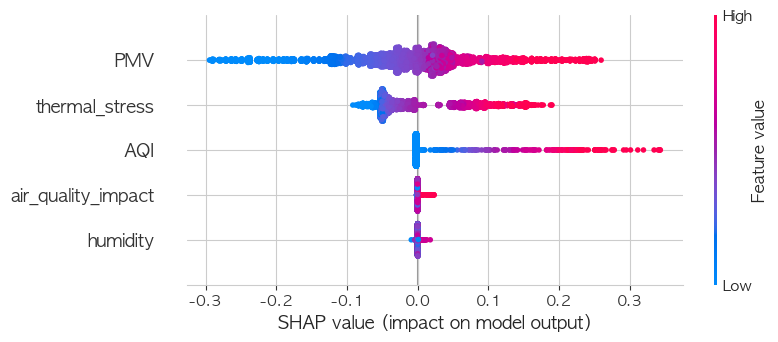

In [8]:
# 8. SHAP 해석
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)
